In [32]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import shapely.vectorized as sv
import os

In [33]:
# Create result map

def store_results_map(cond):

    cap_fac = xr.open_dataset('input_files/world_csp_CF_timeseries_2023_coarse.nc')

    # Create xarray to store results
    result_array = xr.DataArray(
        data=None,
        dims=['x', 'y'],
        coords={
            'x': cap_fac.x,
            'y': cap_fac.y},
        name='breakeven_cost')
    
    # Load the results from the csv files
    csv_dir = f'output_data/breakeven_costs_{cond}/'
    for file in os.listdir(csv_dir):
        result = np.loadtxt(csv_dir + file, delimiter=',')
        result_array.loc[{'x': result[0], 'y': result[1]}] = result[2]

    # Save the results to a netcdf file
    result_array.to_netcdf(f'output_data/breakeven_costs_{cond}.nc')

In [34]:
def plot_result_map(file_path, case_name, cond):
    """
    Plot the capacity factors of the world
    """

    dataset = xr.open_dataset(file_path)
    dataset.close()
    # Reindex the dataset to 0.25 degree resolution
    dataset = dataset.reindex(x=np.arange(-180, 180.25, 0.25), y=np.arange(-57, 85.25, 0.25), method='nearest')

    # Load the world shapefile
    world = gpd.read_file('input_files/ne_110m_admin_0_countries.shp')
    # Drop uninhabited regions and Antarctica
    # region = world[(world.pop_est > 0) & (world.name != "Antarctica")]
    region = world
    # Extract the geometry from the GeoSeries (use unary_union if there are multiple polygons)
    region_geom = region.unary_union if len(region) > 1 else region.iloc[0]

    # Get the grid of coordinates (lon, lat) from the xarray DataArray
    lon, lat = np.meshgrid(dataset['x'], dataset['y'], indexing='ij')

    # Use shapely's vectorized.contains to create a mask for points within the region
    mask = sv.contains(region_geom, lon, lat)

    # Apply the mask to the dataset DataArray
    masked_dataset = dataset.where(mask)

    # Plot the result with 1 step on x axis is the same as 1 step on y axis
    aspect_ratio = (dataset['x'].max()-dataset['x'].min())/(dataset['y'].max()-dataset['y'].min())
    masked_dataset[f'breakeven_cost'].plot(x='x', y='y', aspect=aspect_ratio, size=5, cmap='viridis', cbar_kwargs={'label': 'Breakeven cost of gas ($/MWh)'}, vmin=0)
    # Remove x and y labels and ticks
    plt.gca().set_xticks([])
    plt.gca().set_yticks([])
    plt.gca().set_xlabel('')
    plt.gca().set_ylabel('')
    # Add title
    if cond == 'deployed':
        title = 'Solar thermal deployed'
    else:
        title = 'Solar thermal > 50% of dispatch'
    plt.gca().set_title(title)
    # Remove box around the plot
    for edge in ['top', 'right', 'bottom', 'left']:
        plt.gca().spines[edge].set_visible(False)

    # Save the plot
    if not os.path.exists('figures'):
        os.makedirs('figures')
    plt.savefig(f'figures/csp_fraction_map_{case_name}_{cond}.jpg', bbox_inches='tight', dpi=400)


/tmp/ipykernel_2941300/2753020069.py:17: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  region_geom = region.unary_union if len(region) > 1 else region.iloc[0]
/tmp/ipykernel_2941300/2753020069.py:17: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  region_geom = region.unary_union if len(region) > 1 else region.iloc[0]


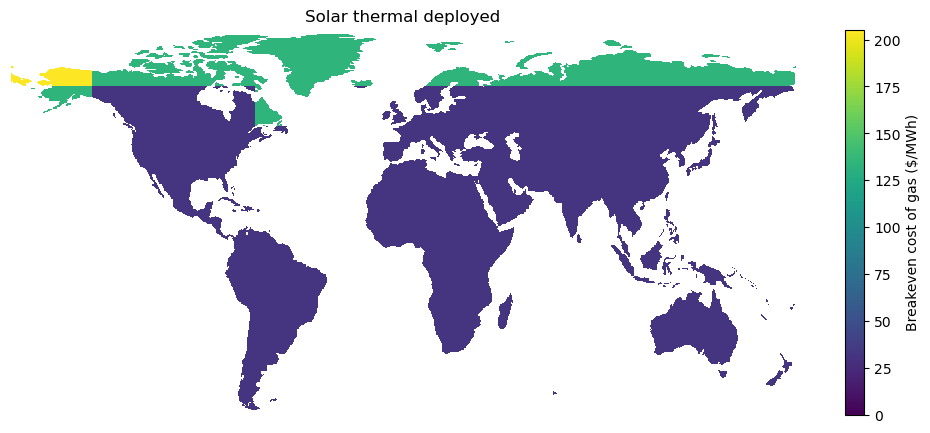

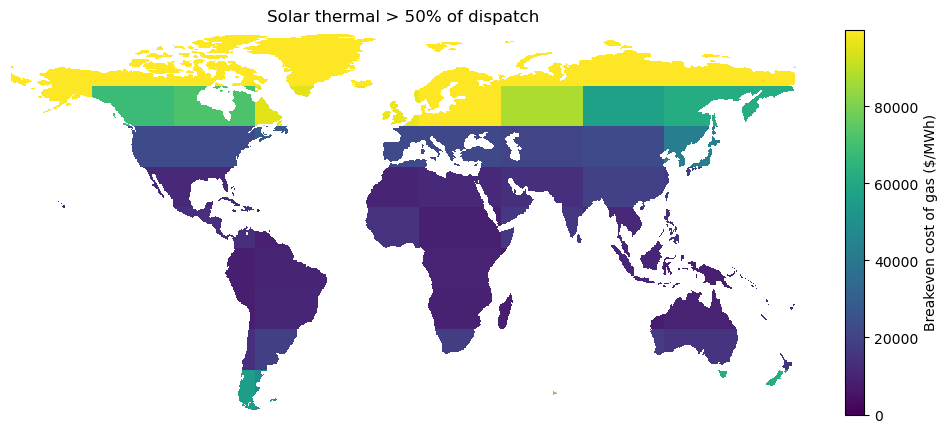

In [35]:
# Plot results
case = 'CSP'
for condition in ['deployed','dominating']: 
    if not os.path.exists(f'output_data/breakeven_costs_{condition}.nc'):
        store_results_map(condition)
    result_file = f'output_data/breakeven_costs_{condition}.nc'

    plot_result_map(result_file, case, condition)